In [1]:
!pip install uproot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 392.4/392.4 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.0/908.0 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.6/653.6 kB 37.9 MB/s eta 0:00:00


In [2]:
!pip install uproot awkward vector numpy scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 kB 6.1 MB/s eta 0:00:00


In [16]:
import uproot
import awkward as ak
import numpy as np

# ===============================
# CONFIG
# ===============================
INPUT_ROOT  = "/kaggle/input/cms2011b-requiredbranches/merged.root"
OUTPUT_ROOT = "stageH_btag.root"

# ===============================
# OPEN FILE
# ===============================
tree = uproot.open(INPUT_ROOT)["Events"]
branches = tree.keys()

# ===============================
# BRANCH FINDERS
# ===============================
def find_branch_contains(prefix, token):
    matches = [b for b in branches if b.startswith(prefix) and token in b]
    if len(matches) == 0:
        raise RuntimeError(f"Missing branch: {prefix}*{token}")
    if len(matches) > 1:
        print(f"⚠ Multiple matches for {prefix}*{token}, using:\n  {matches[0]}")
    return matches[0]

def find_branch_starts(prefix):
    matches = [b for b in branches if b.startswith(prefix)]
    if len(matches) == 0:
        raise RuntimeError(f"Missing branch starting with {prefix}")
    if len(matches) > 1:
        print(f"⚠ Multiple matches for {prefix}, using:\n  {matches[0]}")
    return matches[0]

# ===============================
# JET pT (AK5 PF)
# ===============================
b_jpt = find_branch_contains(
    "recoPFJets_ak5PFJets__RECO",
    "pt_"
)

# ===============================
# B-TAG ASSOCIATIONS
# ===============================
b_csv = find_branch_starts(
    "recoJetedmRefToBaseProdTofloatsAssociationVector_combinedSecondaryVertexBJetTags__RECO"
)
b_jp  = find_branch_starts(
    "recoJetedmRefToBaseProdTofloatsAssociationVector_jetProbabilityBJetTags__RECO"
)
b_tc  = find_branch_starts(
    "recoJetedmRefToBaseProdTofloatsAssociationVector_trackCountingHighEffBJetTags__RECO"
)
b_sm  = find_branch_starts(
    "recoJetedmRefToBaseProdTofloatsAssociationVector_softPFMuonBJetTags__RECO"
)

print("✔ B-tag branches resolved")

# ===============================
# LOAD ARRAYS
# ===============================
arrays = tree.arrays(
    [b_jpt, b_csv, b_jp, b_tc, b_sm],
    library="ak"
)

# ===============================
# LEADING JET INDEX
# ===============================
lead_idx = ak.argmax(arrays[b_jpt], axis=1)

# ===============================
# SAFE LEADING EXTRACTION
# ===============================
def leading(values, lead_idx):
    # build per-event local indices
    local_idx = ak.local_index(values, axis=1)

    # mask the leading jet
    masked = values[local_idx == lead_idx]

    # take first (scalar per event)
    return ak.firsts(masked)


j1_CSV_raw = leading(arrays[b_csv], lead_idx)
j1_JP_raw  = leading(arrays[b_jp],  lead_idx)
j1_TC_raw  = leading(arrays[b_tc],  lead_idx)
j1_SM_raw  = leading(arrays[b_sm],  lead_idx)


# ===============================
# PHYSICS CLEANING (AWKWARD-SAFE)
# ===============================

# CSV ∈ [0,1]
j1_CSV = ak.where(
    j1_CSV_raw < 0, 0.0,
    ak.where(j1_CSV_raw > 1, 1.0, j1_CSV_raw)
)

# JetProbability = exp(-JP) ∈ [0,1]
j1_jetProbability = np.exp(-j1_JP_raw)
j1_jetProbability = ak.where(
    j1_jetProbability < 0, 0.0,
    ak.where(j1_jetProbability > 1, 1.0, j1_jetProbability)
)

# TrackCountingHighEff — keep numerically sane
j1_trackCountingHighEff = ak.where(
    j1_TC_raw < -20, -20.0,
    ak.where(j1_TC_raw > 20, 20.0, j1_TC_raw)
)

# SoftPFMuon — remove NaN / ±inf
j1_softPFMuonBJetTag = ak.where(
    np.isfinite(j1_SM_raw),
    j1_SM_raw,
    0.0
)




# ===============================
# ROOT-SAFE OUTPUT
# ===============================
def to_root(x):
    x = ak.fill_none(x, 0.0)
    x = ak.values_astype(x, np.float32)
    return ak.to_numpy(x)



out = {
    "j1_CSV":                  to_root(j1_CSV),
    "j1_jetProbability":       to_root(j1_jetProbability),
    "j1_trackCountingHighEff": to_root(j1_trackCountingHighEff),
    "j1_softPFMuonBJetTag":    to_root(j1_softPFMuonBJetTag),
}


# ===============================
# WRITE ROOT
# ===============================
with uproot.recreate(OUTPUT_ROOT) as fout:
    fout["Events"] = out

print(f"\n✅ Stage-H Jet Flavor Tagging written → {OUTPUT_ROOT}")


⚠ Multiple matches for recoJetedmRefToBaseProdTofloatsAssociationVector_combinedSecondaryVertexBJetTags__RECO, using:
  recoJetedmRefToBaseProdTofloatsAssociationVector_combinedSecondaryVertexBJetTags__RECO./recoJetedmRefToBaseProdTofloatsAssociationVector_combinedSecondaryVertexBJetTags__RECO.obj/recoJetedmRefToBaseProdTofloatsAssociationVector_combinedSecondaryVertexBJetTags__RECO.obj.data_
⚠ Multiple matches for recoJetedmRefToBaseProdTofloatsAssociationVector_jetProbabilityBJetTags__RECO, using:
  recoJetedmRefToBaseProdTofloatsAssociationVector_jetProbabilityBJetTags__RECO./recoJetedmRefToBaseProdTofloatsAssociationVector_jetProbabilityBJetTags__RECO.obj/recoJetedmRefToBaseProdTofloatsAssociationVector_jetProbabilityBJetTags__RECO.obj.data_
⚠ Multiple matches for recoJetedmRefToBaseProdTofloatsAssociationVector_trackCountingHighEffBJetTags__RECO, using:
  recoJetedmRefToBaseProdTofloatsAssociationVector_trackCountingHighEffBJetTags__RECO./recoJetedmRefToBaseProdTofloatsAssociation


Total events: 452055
Available branches: ['j1_CSV', 'j1_jetProbability', 'j1_trackCountingHighEff', 'j1_softPFMuonBJetTag']

Basic stats:
j1_CSV                       min/max: 0.0 1.0
j1_jetProbability            min/max: 0.0 1.0
j1_trackCountingHighEff      min/max: -20.0 20.0
j1_softPFMuonBJetTag         min/max: -0.4593847990036011 1.0316932201385498

Physics sanity checks:
CSV < -1 events: 0
CSV > 1 events: 0
JetProbability outside [0,1]: 0
TrackCountingHighEff < 0: 115428
SoftPFMuonBJetTag < 0: 521

Valid b-tag events: 336232


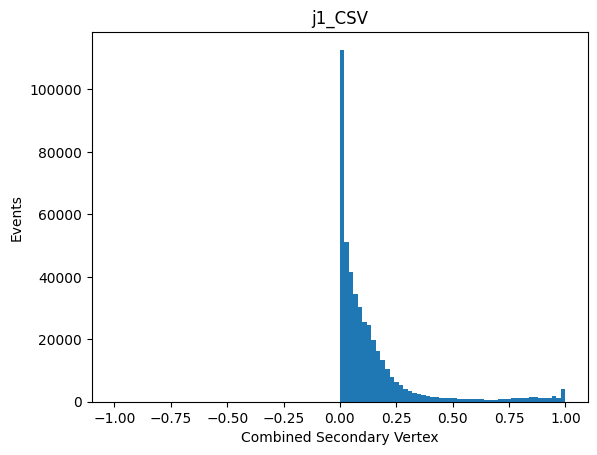

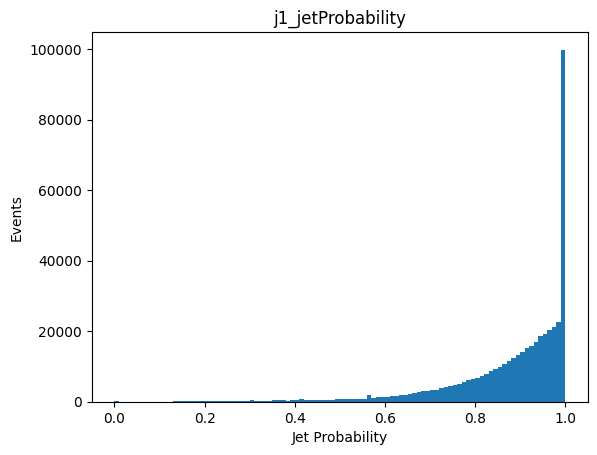

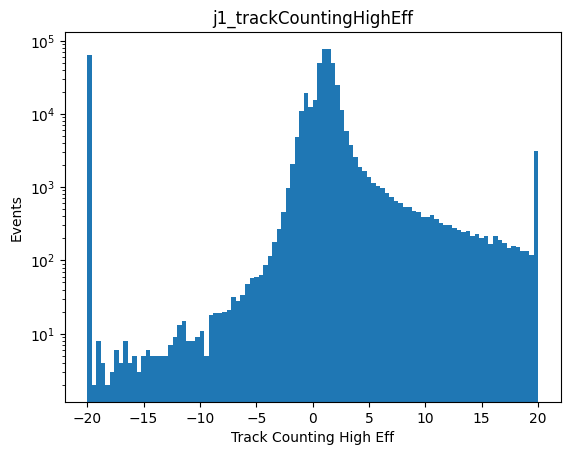

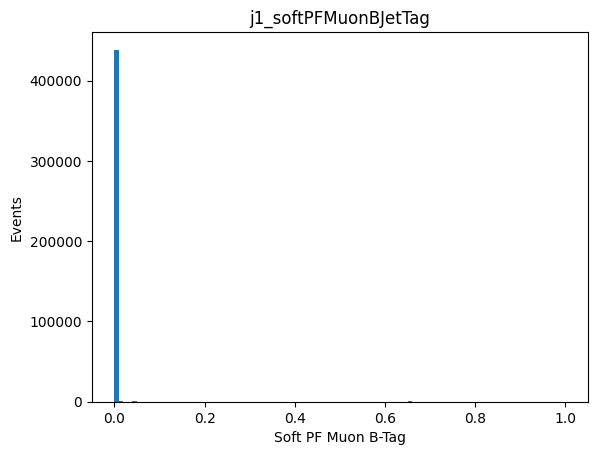


✔ Stage-H B-tag EDA complete.


In [17]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt

# ===============================
# LOAD ROOT FILE
# ===============================
FILE = "/kaggle/working/stageH_btag.root"
tree = uproot.open(FILE)["Events"]
arr = tree.arrays(library="ak")

print("\nTotal events:", len(arr))
print("Available branches:", list(arr.fields))

# ===============================
# BASIC STATS
# ===============================
print("\nBasic stats:")
for k in arr.fields:
    print(
        f"{k:28s} min/max:",
        float(ak.min(arr[k])),
        float(ak.max(arr[k]))
    )

# ===============================
# PHYSICS SANITY CHECKS
# ===============================
print("\nPhysics sanity checks:")

print("CSV < -1 events:",
      ASSERT := ak.sum(arr.j1_CSV < -1))

print("CSV > 1 events:",
      ak.sum(arr.j1_CSV > 1))

print("JetProbability outside [0,1]:",
      ak.sum((arr.j1_jetProbability < 0) | (arr.j1_jetProbability > 1)))

print("TrackCountingHighEff < 0:",
      ak.sum(arr.j1_trackCountingHighEff < 0))

print("SoftPFMuonBJetTag < 0:",
      ak.sum(arr.j1_softPFMuonBJetTag < 0))

# ===============================
# VALID EVENT MASK
# ===============================
mask_valid = (
    (arr.j1_CSV >= -1) &
    (arr.j1_jetProbability >= 0) &
    (arr.j1_trackCountingHighEff >= 0) &
    (arr.j1_softPFMuonBJetTag >= 0)
)

print("\nValid b-tag events:", ak.sum(mask_valid))

# ===============================
# HISTOGRAMS
# ===============================

def hist(x, bins=100, rng=None, log=False, title="", xlabel=""):
    plt.figure()
    plt.hist(ak.to_numpy(x), bins=bins, range=rng, log=log)
    plt.xlabel(xlabel)
    plt.ylabel("Events")
    plt.title(title)
    plt.show()

# 1️⃣ CSV
hist(
    arr.j1_CSV,
    bins=100,
    rng=(-1, 1),
    title="j1_CSV",
    xlabel="Combined Secondary Vertex"
)

# 2️⃣ Jet Probability
hist(
    arr.j1_jetProbability,
    bins=100,
    rng=(0, 1),
    title="j1_jetProbability",
    xlabel="Jet Probability"
)

# 3️⃣ Track Counting High Efficiency
hist(
    arr.j1_trackCountingHighEff,
    bins=100,
    log=True,
    title="j1_trackCountingHighEff",
    xlabel="Track Counting High Eff"
)

# 4️⃣ Soft PF Muon B-Tag
hist(
    arr.j1_softPFMuonBJetTag,
    bins=100,
    rng=(0, 1),
    title="j1_softPFMuonBJetTag",
    xlabel="Soft PF Muon B-Tag"
)

print("\n✔ Stage-H B-tag EDA complete.")
